In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import Progbar

import time 
import pandas as pd
import numpy as np
import json
import re
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

from bs4 import BeautifulSoup
from sklearn.preprocessing import MultiLabelBinarizer


In [2]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [3]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.1.0
Eager execution: True


In [4]:
VOCAB_WORDLIMIT = 20000
SEQUENCE_LEN = 2000
BATCH_SIZE = 210
EPOCHS = 5
LEARNING_RATE = 1e-3

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [5]:
def clean_text(text):
 text = BeautifulSoup(text, "lxml").text
 text = text.lower() # lowercase text
 text = REPLACE_BY_SPACE_RE.sub(' ', text)
 text = BAD_SYMBOLS_RE.sub('', text)
 text = ' '.join(word for word in text.split() if word not in STOPWORDS)
 return text

In [6]:
def download_movie_file(movie_file):
    df_movie = pd.read_csv(movie_file, engine='python', sep = '\t', header = None,
                     quotechar='"', error_bad_lines=False, warn_bad_lines=False)
    df_movie.info()
    return df_movie

In [7]:
movie_file = 'movie.metadata.tsv'
df_movie = download_movie_file(movie_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81735 entries, 0 to 81734
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       81735 non-null  int64  
 1   1       81735 non-null  object 
 2   2       81735 non-null  object 
 3   3       74833 non-null  object 
 4   4       8401 non-null   float64
 5   5       61287 non-null  float64
 6   6       81735 non-null  object 
 7   7       81735 non-null  object 
 8   8       81735 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [8]:
def download_plot_file(plot_file):
    df_plot = pd.read_csv(plot_file, engine='python', sep = '\t', header = None,
                     quotechar='"', error_bad_lines=False, warn_bad_lines=False)
    df_plot.info()
    return df_plot

In [9]:
plot_file = 'plot_summaries.txt'
df_plot = download_plot_file(plot_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42171 entries, 0 to 42170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       42171 non-null  int64 
 1   1       42171 non-null  object
dtypes: int64(1), object(1)
memory usage: 659.0+ KB


In [10]:
def merge_files():
    df_movie.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
    df_plot.columns = ["movie_id", "plot"]

    df_movie_sub = df_movie[["movie_id","movie_name","genre"]]

    df_movie_sub = df_movie_sub[["movie_id","movie_name","genre"]]
    df_movie_sub['movie_id'] = df_movie_sub['movie_id'].astype(str)

    df_plot['movie_id'] = df_plot['movie_id'].astype(str)
    df_movie_merge = pd.merge(df_plot, df_movie_sub, on = 'movie_id')

    genres_list = []
    for i in df_movie_merge['genre']:
        genres_list.append(list(json.loads(i).values()))

    df_movie_merge['genre'] = genres_list
    df_movie_merge['plot'] = df_movie_merge['plot'].apply(clean_text)
    
    return df_movie_merge

In [11]:
df_movie_merge = merge_files()

In [12]:
def hot_encode():
    mlb = MultiLabelBinarizer()
    mlb.fit_transform(df_movie_merge['genre'])
    Y = mlb.transform(df_movie_merge['genre'])

    print('Y hot encoded ->', type(Y), Y.shape, len(Y))

    for idx, genre in enumerate(mlb.classes_):
      df_movie_merge[genre] = Y[:,idx]

    Y_labels = df_movie_merge.columns.tolist()[4::]
    print('Y_labels ->', type(Y_labels), len(Y_labels))

    assert (len(Y[1])==len(Y_labels)), "num of labels do not match with hot enconded list"
    
    return Y_labels, Y

In [13]:
Y_labels, Y = hot_encode()

Y hot encoded -> <class 'numpy.ndarray'> (42071, 362) 42071
Y_labels -> <class 'list'> 362


In [14]:
##### saving cleaneup merged movie and reloading
def save_reload_merged_file(df_movie_merge):
    df_movie_merge.to_csv('movie.csv')
    movie_new = pd.read_csv('movie.csv')
    df_movie_merge = movie_new
    df_movie_merge.head(3)
    return df_movie_merge

In [15]:
df_movie_merge = save_reload_merged_file(df_movie_merge)

In [16]:
def vectorize_X_input():
    df_movie_merge['plot'] = df_movie_merge['plot'].astype(str)
    
    tokenizer = Tokenizer(num_words=VOCAB_WORDLIMIT,
                          filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df_movie_merge['plot'].values)
    movie_plot_vocab = tokenizer.word_index
    
    X = tokenizer.texts_to_sequences(df_movie_merge['plot'].values)
    X = pad_sequences(X, maxlen=SEQUENCE_LEN)
    
    print("movie_plot_vocab: {}, {}, size limited to: {}".format(
        type(movie_plot_vocab), len(movie_plot_vocab),VOCAB_WORDLIMIT))

    print('Shape of X input tensor (elements, SEQUENCE_LEN) :', X.shape)
    
    return X

In [17]:
X = vectorize_X_input()

movie_plot_vocab: <class 'dict'>, 184205, size limited to: 20000
Shape of X input tensor (elements, SEQUENCE_LEN) : (42071, 2000)


In [18]:
X.shape, X

((42071, 2000),
 array([[    0,     0,     0, ...,   549,  5095,   482],
        [    0,     0,     0, ...,  1285,  2360,   419],
        [    0,     0,     0, ..., 12879,    11,   640],
        ...,
        [    0,     0,     0, ...,   485,   482,    39],
        [    0,     0,     0, ...,  3110,     2,  6817],
        [    0,     0,     0, ...,  2725,   501,  5182]], dtype=int32))

In [19]:
Y.shape, Y

((42071, 362),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [20]:
assert len(X)==len(Y), "num of 'X inputs' must be equal to num of 'Y outputs'"

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.99, random_state = 42)
print("X & Y training shapes:{} & {}".format(X_train.shape, Y_train.shape))
print("X & Y testing  shapes:{} & {}".format(X_test.shape, Y_test.shape))
print("X_train:\n", X_train)
print("Y_train:\n", Y_train)

X & Y training shapes:(420, 2000) & (420, 362)
X & Y testing  shapes:(41651, 2000) & (41651, 362)
X_train:
 [[    0     0     0 ...   628     8   988]
 [    0     0     0 ...    99  2043   894]
 [    0     0     0 ...   232  5249  7861]
 ...
 [    0     0     0 ...  3255    29 16117]
 [    0     0     0 ...  2587  2601  1160]
 [    0     0     0 ...   555    70  6607]]
Y_train:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [22]:
assert len(X_train)==len(Y_train), "num of 'X inputs' must be equal to num of 'Y outputs'"

In [23]:
def build_model():
    label_count = len(Y[1])
    deep_inputs = Input(shape=(SEQUENCE_LEN,))
    embedding_layer = Embedding(VOCAB_WORDLIMIT, 100)(deep_inputs)
    lstm_layer_1 = LSTM(128)(embedding_layer)
    output_layer = Dense(label_count, activation='sigmoid')(lstm_layer_1)
    model = Model(inputs=deep_inputs, outputs=output_layer)
    
    return model

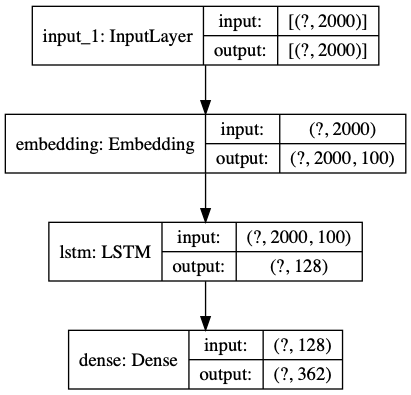

In [24]:
model = build_model()
plot_model(model, 'model.png', show_shapes=True)

In [25]:
def test_model_predictions(X_test):
    print("input shape and value:", X_test.shape, '\n', X_test, '\n')
    input = tf.expand_dims(X_test,0)
    
    Y_pred = model.predict(input)
    print("predicted output shape, min, min and std deviations -> shape: {} \nY_pred Max: {},  Y_pred Min: {}, Y_pred Std.: {}".format(
        Y_pred.shape, np.max(Y_pred,1),  np.min(Y_pred,1), np.std(Y_pred,1)))


In [26]:
test_model_predictions(X[0])

input shape and value: (2000,) 
 [   0    0    0 ...  549 5095  482] 

predicted output shape, min, min and std deviations -> shape: (1, 362) 
Y_pred Max: [0.50314367],  Y_pred Min: [0.4966852], Y_pred Std.: [0.00113463]


In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def compute_loss(model, x, y, training):
    y_pred = model(x, training=training)
    return loss_object(y, y_pred)


In [28]:
def test_compute_loss():
    computed_loss = compute_loss(model,
                                 tf.expand_dims(X[0],0),
                                 tf.expand_dims(Y[0],0),
                                 training=False)
    print("<testing compute_loss function> using X[0] and Y[0]_pred :\ncomputed_loss = {} ".format
          (computed_loss))

In [29]:
test_compute_loss()

<testing compute_loss function> using X[0] and Y[0]_pred :
computed_loss = 0.9712542295455933 


In [30]:
def compute_gradient(model, x, y):
  with tf.GradientTape() as tape:
    computed_loss = compute_loss(model, x, y, training=True)
    computed_gradient = tape.gradient(computed_loss, model.trainable_variables)
    
  return computed_loss, computed_gradient

In [31]:
def test_compute_gradient():
    loss, gradient = compute_gradient(
        model, tf.expand_dims(X[0],0), tf.expand_dims(Y[0],0))
    print("loss for X[0] input ->", loss)
    print("gradient value for X[0], Y[0]->", type(gradient), len(gradient))

In [32]:
test_compute_gradient()

loss for X[0] input -> tf.Tensor(0.9712542, shape=(), dtype=float32)
gradient value for X[0], Y[0]-> <class 'list'> 6


In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [34]:
def test_optimization(model, x, y):
    loss, gradient = compute_gradient(model, x, y)
    
    print("Step: {}, Initial Loss: {}".format(
        optimizer.iterations.numpy(), loss.numpy()))
    
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    
    print("Step: {}, Optimized Loss: {}".format(optimizer.iterations.numpy(),
                                      compute_loss(model, x, y, training=True).numpy()))


In [35]:
test_optimization(model,
                  tf.expand_dims(X[0],0),
                  tf.expand_dims(Y[0],0),)


Step: 0, Initial Loss: 0.9712542295455933
Step: 1, Optimized Loss: 0.9708912968635559


In [36]:
def train_batch(x, y):
    computed_loss, computed_gradient = compute_gradient(model, x, y)
    optimizer.apply_gradients(zip(computed_gradient, model.trainable_variables))
    epoch_loss_avg(computed_loss)
    epoch_accuracy(y, model(x, training=True))
    
    return epoch_loss_avg, epoch_accuracy

In [37]:
train_loss_results = []
train_accuracy_results = []
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.BinaryAccuracy()

metrics_names = ['loss','accuracy'] 


def train_all(X, Y):
    num_of_batches = math.floor(len(X) / BATCH_SIZE)
    for epoch in range(EPOCHS):
        print("\nepoch {}/{}".format(epoch+1,EPOCHS))
        pb_epoch = Progbar(len(X), stateful_metrics=metrics_names)
        for idx in range(num_of_batches):
            time.sleep(0.3)
            start_at = idx * BATCH_SIZE
            end_at = start_at + BATCH_SIZE
            epoch_loss_avg, epoch_accuracy = train_batch(X[start_at:end_at], Y[start_at:end_at])
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        
        values=[('loss', epoch_loss_avg.result()), ('accuracy', epoch_accuracy.result())]
        pb_epoch.add(BATCH_SIZE, values=values)
    
    print('\n========= Training Ended ===========')


In [38]:
train_all(X_train, Y_train)


epoch 1/5
210/420 [==============>...............] - ETA: 38s - loss: 0.9688 - accuracy: 0.7465
epoch 2/5
210/420 [==============>...............] - ETA: 37s - loss: 0.9686 - accuracy: 0.7978
epoch 3/5
210/420 [==============>...............] - ETA: 37s - loss: 0.9682 - accuracy: 0.8265
epoch 4/5
210/420 [==============>...............] - ETA: 36s - loss: 0.9677 - accuracy: 0.8422
epoch 5/5
210/420 [==============>...............] - ETA: 36s - loss: 0.9666 - accuracy: 0.8521
========= Training Ended ===========


In [39]:
def visualize_losses():
    fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(train_loss_results)

    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=14)
    axes[1].plot(train_accuracy_results)
    plt.show()

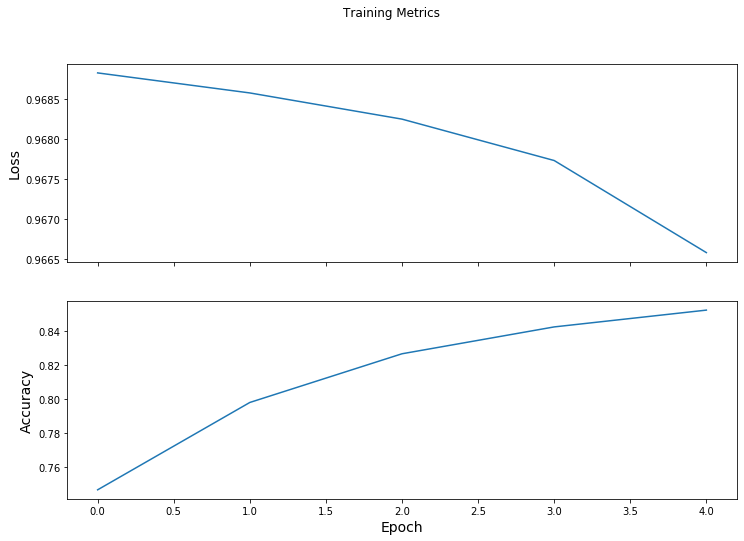

In [40]:
visualize_losses()